# GPX 3d Viewer App

## Imports

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt

## GPX to Dataframe

In [11]:
import gpxpy
import pandas as pd
! open .

# Load gpx.
gpx_path = 'gpx_viewer/data/Morvan_day2.gpx'
with open(gpx_path) as f:
    gpx = gpxpy.parse(f)

# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
df = pd.DataFrame.from_records(points)

## FIT to Dataframe

In [12]:
import fitdecode
from typing import Dict, Union, Optional,Tuple
from datetime import datetime, timedelta

# The names of the columns we will use in our points DataFrame. For the data we will be getting
# from the FIT data, we use the same name as the field names to make it easier to parse the data.
POINTS_COLUMN_NAMES = ['latitude', 'longitude', 'lap', 'altitude', 'timestamp', 'heart_rate', 'cadence', 'speed']

# The names of the columns we will use in our laps DataFrame. 
LAPS_COLUMN_NAMES = ['number', 'start_time', 'total_distance', 'total_elapsed_time',
                     'max_speed', 'max_heart_rate', 'avg_heart_rate']


def get_fit_lap_data(frame: fitdecode.records.FitDataMessage) -> Dict[str, Union[float, datetime, timedelta, int]]:
    """Extract some data from a FIT frame representing a lap and return
    it as a dict.
    """
    
    data: Dict[str, Union[float, datetime, timedelta, int]] = {}
    
    for field in LAPS_COLUMN_NAMES[1:]:  # Exclude 'number' (lap number) because we don't get that
                                        # from the data but rather count it ourselves
        if frame.has_field(field):
            data[field] = frame.get_value(field)
    
    return data


def get_fit_point_data(frame: fitdecode.records.FitDataMessage) -> Optional[Dict[str, Union[float, int, str, datetime]]]:
    """Extract some data from an FIT frame representing a track point
    and return it as a dict.
    """
    
    data: Dict[str, Union[float, int, str, datetime]] = {}
    
    if not (frame.has_field('position_lat') and frame.has_field('position_long')):
        # Frame does not have any latitude or longitude data. We will ignore these frames in order to keep things
        # simple, as we did when parsing the TCX file.
        return None
    else:
        data['latitude'] = frame.get_value('position_lat') / ((2**32) / 360)
        data['longitude'] = frame.get_value('position_long') / ((2**32) / 360)
    
    for field in POINTS_COLUMN_NAMES[3:]:
        if frame.has_field(field):
            data[field] = frame.get_value(field)
    
    return data


def get_dataframes(fname: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Takes the path to a FIT file (as a string) and returns two Pandas
    DataFrames: one containing data about the laps, and one containing
    data about the individual points.
    """

    points_data = []
    laps_data = []
    lap_no = 1
    with fitdecode.FitReader(fname) as fit_file:
        for frame in fit_file:
            if isinstance(frame, fitdecode.records.FitDataMessage):
                if frame.name == 'record':
                    single_point_data = get_fit_point_data(frame)
                    if single_point_data is not None:
                        single_point_data['lap'] = lap_no
                        points_data.append(single_point_data)
                elif frame.name == 'lap':
                    single_lap_data = get_fit_lap_data(frame)
                    single_lap_data['number'] = lap_no
                    laps_data.append(single_lap_data)
                    lap_no += 1
    
    # Create DataFrames from the data we have collected. If any information is missing from a particular lap or track
    # point, it will show up as a null value or "NaN" in the DataFrame.
    
    laps_df = pd.DataFrame(laps_data, columns=LAPS_COLUMN_NAMES)
    laps_df.set_index('number', inplace=True)
    points_df = pd.DataFrame(points_data, columns=POINTS_COLUMN_NAMES)
    
    return laps_df, points_df

In [89]:
test_fit_path = 'gpx_viewer/data/8685365728.fit'
laps_df, fit_df = get_dataframes(test_fit_path)

/Users/chloeguillaume/.pyenv/versions/lewagon/lib/python3.8/site-packages/fitdecode/reader.py:909: UserWarning:

'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 134); adding dummy dev data...

/Users/chloeguillaume/.pyenv/versions/lewagon/lib/python3.8/site-packages/fitdecode/reader.py:909: UserWarning:

'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 154); adding dummy dev data...

/Users/chloeguillaume/.pyenv/versions/lewagon/lib/python3.8/site-packages/fitdecode/reader.py:909: UserWarning:

'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 195); adding dummy dev data...

/Users/chloeguillaume/.pyenv/versions/lewagon/lib/python3.8/site-packages/fitdecode/reader.py:909: UserWarning:

'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 241); ad

In [90]:
fit_df.head()

,latitude,longitude,lap,altitude,timestamp,heart_rate,cadence,speed
0,47.166584,4.110838,1,627.6,2022-11-13 09:06:20+00:00,159,NaN,2.588
1,47.166606,4.110829,1,627.4,2022-11-13 09:06:21+00:00,159,NaN,2.552
2,47.166629,4.110819,1,627.4,2022-11-13 09:06:22+00:00,158,NaN,2.781
3,47.166655,4.110818,1,627.4,2022-11-13 09:06:23+00:00,155,NaN,2.897
4,47.166681,4.110817,1,627.4,2022-11-13 09:06:24+00:00,155,NaN,2.692


In [102]:
fit_df.rename(columns={'altitude':'elevation','timestamp':'time'})
fit_df[['distance']] = points_df[['speed']].cumsum()/1000
fit_df[['distance']]= fit_df[['distance']].round(3)
fit_df[['speed_km_h']] = points_df[['speed']]*3600/1000
fit_df[['speed_km_h']] = points_df[['speed']]*3600/1000
fit_df[['elev_diff']] = fit_df[['altitude']].diff()
fit_df['d+'] = fit_df[fit_df['elev_diff']>0]['elev_diff'].cumsum().round(2)
fit_df = fit_df.fillna(method='ffill')
# Cumul Elevation
fit_df['elev_cum'] = fit_df.elev_diff.cumsum().round(2)
# Avg deniv for color
n=60
fit_df['d_avg'] = fit_df['elev_diff'].rolling(n).sum().round(2)

KeyError: "None of [Index(['altitude'], dtype='object')] are in the [columns]"

In [103]:
fit_df

,latitude,longitude,lap,elevation,time,heart_rate,cadence,speed,distance,speed_km_h,elev_diff,d+,elev_cum,d_avg
0,47.166584,4.110838,1,627.6,2022-11-13 09:06:20+00:00,159,NaN,2.588,0.003,9.3168,NaN,NaN,NaN,NaN
1,47.166606,4.110829,1,627.4,2022-11-13 09:06:21+00:00,159,NaN,2.552,0.005,9.1872,-0.2,NaN,-0.2,NaN
2,47.166629,4.110819,1,627.4,2022-11-13 09:06:22+00:00,158,NaN,2.781,0.008,10.0116,0.0,NaN,-0.2,NaN
3,47.166655,4.110818,1,627.4,2022-11-13 09:06:23+00:00,155,NaN,2.897,0.011,10.4292,0.0,NaN,-0.2,NaN
4,47.166681,4.110817,1,627.4,2022-11-13 09:06:24+00:00,155,NaN,2.692,0.014,9.6912,0.0,NaN,-0.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7458,47.166586,4.110852,1,625.8,2022-11-13 11:27:03+00:00,167,NaN,3.624,45.133,13.0464,0.0,657.0,-1.8,7.2
7459,47.166555,4.110852,1,625.8,2022-11-13 11:27:04+00:00,167,NaN,3.505,45.137,12.6180,0.0,657.0,-1.8,7.2
7460,47.166525,4.110847,1,626.0,2022-11-13 11:27:05+00:00,167,NaN,3.318,45.140,11.9448,0.2,657.2,-1.6,7.2
7461,47.166501,4.110839,1,626.0,2022-11-13 11:27:06+00:00,167,NaN,2.657,45.143,9.5652,0.0,657.2,-1.6,7.2


In [18]:
points_df.speed_km_h.mean()

21.776582821921483

In [19]:
points_df.speed_km_h.max()

60.7356

## Features Engineering

In [84]:
# Duration
df[['duration']] = df[['time']] - df[['time']].iloc[0]
#df['duration'] = df['duration'].apply(str)
df.head()

,time,latitude,longitude,elevation,duration,elev_diff,d+,elev_cum,d_avg,seconds,Time
0,2022-11-13 09:06:20+00:00,47.166584,4.110838,627.6,0 days 00:00:00,NaN,NaN,NaN,NaN,0.0,09:06:20
1,2022-11-13 09:06:21+00:00,47.166606,4.110829,627.4,0 days 00:00:01,-0.2,NaN,-0.2,NaN,1.0,09:06:21
2,2022-11-13 09:06:22+00:00,47.166629,4.110819,627.4,0 days 00:00:02,0.0,NaN,-0.2,NaN,2.0,09:06:22
3,2022-11-13 09:06:23+00:00,47.166655,4.110818,627.4,0 days 00:00:03,0.0,NaN,-0.2,NaN,3.0,09:06:23
4,2022-11-13 09:06:24+00:00,47.166681,4.110817,627.4,0 days 00:00:04,0.0,NaN,-0.2,NaN,4.0,09:06:24


In [87]:
# Convert timedelta to seconds to datetime to apply format
#df['duration'] = pd.to_datetime(df['duration'].dt.total_seconds(),unit='s').dt.strftime("%H:%M:%S")

0      0 days 00:00:00
1      0 days 00:00:01
2      0 days 00:00:02
3      0 days 00:00:03
4      0 days 00:00:04
             ...      
7458   0 days 02:20:43
7459   0 days 02:20:44
7460   0 days 02:20:45
7461   0 days 02:20:46
7462   0 days 02:20:47
Name: duration, Length: 7463, dtype: timedelta64[ns]

In [23]:
# D+
df[['elev_diff']] = df[['elevation']].diff()
df['d+'] = df[df['elev_diff']>0]['elev_diff'].cumsum().round(2)
df = df.fillna(method='ffill')

In [24]:
# Cumul Elevation
df['elev_cum'] = df.elev_diff.cumsum().round(2)
df.head()

,time,latitude,longitude,elevation,duration,elev_diff,d+,elev_cum
0,2022-11-13 09:06:20+00:00,47.166584,4.110838,627.6,0 days 00:00:00,NaN,NaN,NaN
1,2022-11-13 09:06:21+00:00,47.166606,4.110829,627.4,0 days 00:00:01,-0.2,NaN,-0.2
2,2022-11-13 09:06:22+00:00,47.166629,4.110819,627.4,0 days 00:00:02,0.0,NaN,-0.2
3,2022-11-13 09:06:23+00:00,47.166655,4.110818,627.4,0 days 00:00:03,0.0,NaN,-0.2
4,2022-11-13 09:06:24+00:00,47.166681,4.110817,627.4,0 days 00:00:04,0.0,NaN,-0.2


<AxesSubplot:>

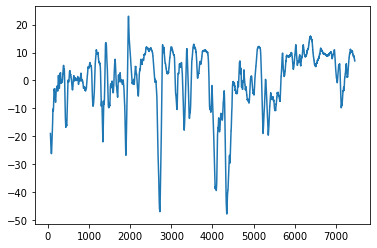

In [25]:
# Avg deniv for color
n=60
df['d_avg'] = df['elev_diff'].rolling(n).sum().round(2)
df.d_avg.plot()

In [26]:
# 3d GPS coordinates scatter
fig_3 = px.scatter_3d(df, x='longitude', y='latitude', z='elevation', color='d_avg', template='plotly_dark',hover_name='d+',title='3d profile - Elevation highlight')
fig_3.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
fig_3.update_layout(scene = {"xaxis": {"nticks": 5},
                             "zaxis": {"nticks": 10},
                             "camera_eye": {"x": 0.3, "y": -1, "z": 0.3},
                             "aspectratio": {"x": 1, "y": 0.7, "z": 0.25}},
                    height=600
                   )

fig_3.show()

In [27]:
# 2d Map GPS coordinates - Free
fig_4 = px.scatter_mapbox(df, lat='latitude', lon='longitude', hover_name='d+',
                          mapbox_style="open-street-map",
                          zoom=11,
                          color='d_avg',
                          title='2d map - Elevation highlight',
                          template='plotly_dark',
                          height=600
                      )
fig_4.update_traces(marker=dict(size=5), selector=dict(mode='markers'))

fig_4.show()

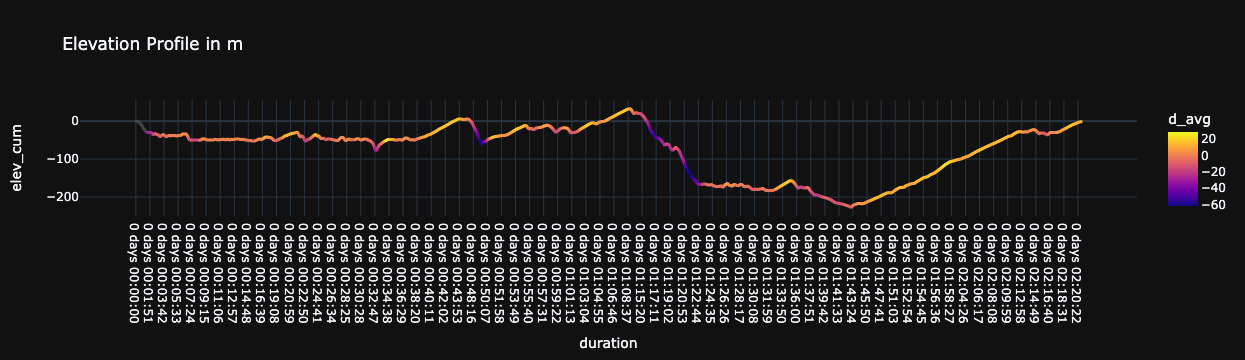

In [61]:
fig_2 = px.scatter(df, x='duration', y='elev_cum',color='d_avg',template='plotly_dark',hover_name='d+',title='Elevation Profile in m')
fig_2.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig_2.show()

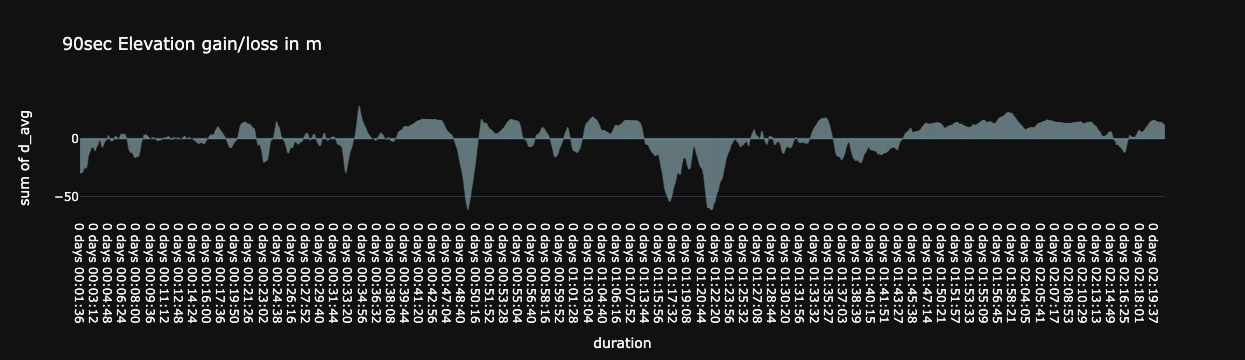

In [89]:
fig_1 = px.histogram(df, x='duration', y='d_avg',template='plotly_dark',hover_name='d+',title='90sec Elevation gain/loss in m',color_discrete_sequence=['lightblue'],opacity=0.85)
fig_1.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig_1.show()

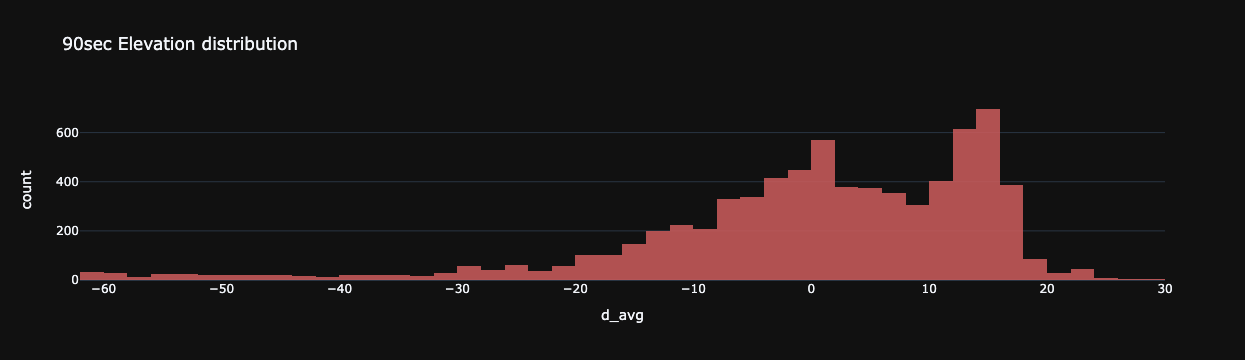

In [90]:
fig_5 = px.histogram(df, x='d_avg',template='plotly_dark',hover_name='d+',title='90sec Elevation distribution',nbins=50,color_discrete_sequence=['indianred'],opacity=0.85)
fig_5.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig_5.show()

## Dash by plotly

In [91]:
#!pip install dash-bootstrap-components

In [92]:
import dash
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input,Output
import dash_bootstrap_components as dbc

In [93]:
# Dash generic template + layout design
#app = JupyterDash(__name__)
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

title = html.H1("GPX Viewer App")

map_2d = dcc.Graph(figure=fig_4)
map_3d = dcc.Graph(figure=fig_3)
elev_line = dcc.Graph(figure=fig_2)
d_avg = dcc.Graph(figure=fig_1)
histo = dcc.Graph(figure=fig_5)

row_1 = map_2d
row_2 = map_3d
row_3 = elev_line
row_4 = d_avg
row_5 = histo

app.layout = html.Div([
    title,
    row_1,
    row_2,
    row_3,
    row_4,
    row_5
])

            

In [94]:
# to run the app
app.run_server()

Dash app running on http://127.0.0.1:8050/
